In [1]:
import numpy as np
import pandas as pd

In [2]:
# Import MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x[0]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
y[0]

'5'

In [6]:
# Convert target variable to integer
y = y.astype(np.uint8)

In [7]:
# Train test split
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [8]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [9]:
# Binary classifier for the number 5

# New target vectors (return t/f for target 5)
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# Prediction
sgd_clf.predict([some_digit])

array([ True])

In [13]:
# Cross validation from scratch
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9646696108657612
0.957
0.9551666666666667
0.9573333333333334
0.9673306108842403


In [ ]:
# Sklearn automatic cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=5, scoring='accuracy')

In [17]:
# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=5)
confusion_matrix(y_train_5, y_train_pred)


array([[53677,   902],
       [ 1480,  3941]], dtype=int64)

In [19]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8137518067313648, 0.7269876406567054)

In [20]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7679267342166797

In [22]:
# Using custom decision threshold
# decision_fucntion returns a score for each instance

y_scores = sgd_clf.decision_function([some_digit])
y_scores


array([2164.22030239])

In [24]:
# Definie threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

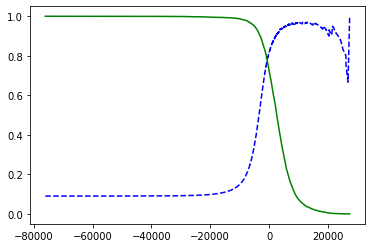

In [25]:
# Fine tuning threshold

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=5, 
                            method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
# Search threshold for a terget precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

2266.040057259482

In [30]:
# Making prediction using threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9001540832049306, 0.5388304740822727)

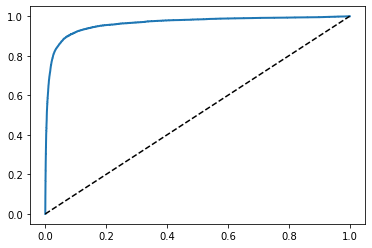

In [31]:
# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
# ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9633444355044527

In [34]:
# Random forest 
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=5, 
                                   method='predict_proba')

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 

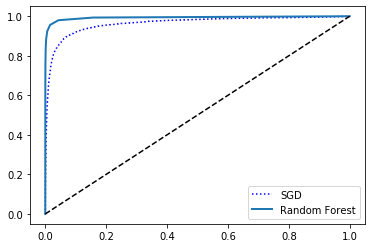

In [35]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9933511587661912

In [43]:
y_pred_forest = (y_scores_forest>0.55)

precision_score(y_train_5, y_pred_forest), recall_score(y_train_5, y_pred_forest)

(0.9845450587723117, 0.8343479062903524)

In [11]:
# Multiclass classifier
# SGDClassifier
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
# Score for each class
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
# Index of highest score
np.argmax(some_digit_scores)

3

In [48]:
# Classes predicted
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
# Specifying one vs one strategy
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
# Number of classifiers builts
len(ovo_clf.estimators_)

45

In [51]:
# Random Forest
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [52]:
# Probability for each class
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [53]:
cross_val_score(sgd_clf, x_train, y_train, cv=5,
               scoring='accuracy')

array([0.8849646 , 0.87627062, 0.87341667, 0.86388264, 0.87062354])

In [14]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

In [15]:
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

D:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
# Multiclass confusion matrix
y_train_pred = cross_val_predict(sgd_clf, x_train_sclaed, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# The graph above shows the total number of errors is biased against abundant classes
# Dividing by the number of each class to 'normalize'
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [16]:
# Excercises